# A comparison of "A Game Theoretic Framework for Model-Based Reinforcement Learning" with a random sampling approach

This notebook is part of the course "Practical training: Optimizing Experiment Design" at University of Osnabrueck. This notebook is therefore based on the [GitHub](https://github.com/whyhardt/CourseOptimizingExperimentalDesign) of the course.

This experiment will be concerned with applying a game theoretic framework for model based reinforcement learning (MBRL), which was developed by [Rajeswaran et al.](https://doi.org/10.48550/arXiv.2004.07804), to an approach for optimal experimental design. For thw optimal experimental design part, we will use the automated research assistant ([AutoRA](https://autoresearch.github.io/autora/)) as a tool.

We will be comparing a ramdom sampling approach, in particular latin hypercube, to the framework by Rajeswaran et al. in terms of their efficiency/effectivity. The gist of our approach to combining the framework of Rajeswaran et al. and the wokflow of AutoRA is that  we set the theorist of AutoRA as the model player of Rajeswaran et al. and the experimentalist of AutoRA as the policy player of [Rajeswaran et al.](https://doi.org/10.48550/arXiv.2004.07804)


## General Information

### The Approach

The approach by [Rajeswaran et al.](https://doi.org/10.48550/arXiv.2004.07804) is a game theoretic MBRL framwork that is conceptualized as a stackelberg game. A stackelberg game is characterized by asymmetry, as players make decisions in a
pre-specified order. The leader plays first and subsequently the follower.  So they players get the chance to react to one another. Two different approaches exist whithin this framework. MAL (Model as Leader) and PAL (Policy as Leader).



### The Experiment

As a demo experiment, to compare the new approach to a random sampling method, we will use the two-alternative-forced-choice (2AFC) experiment. In this experiment, an image is shown to the participants for a short period of time. In this, an image which shows a grid of either orange or blue tiles or a mix of both is shown to participants. Participants then have to decide whether there are more orange or blue tiles in total. An example can be seen below.

Two factors can be tweaked to control the experiment. The two factors are ratio and scatterdness. Ratio determines the amount of blue vs orange tiles, where 0 means that the participant sees only orange tiles while 1 means that the amount of blue vs orange tiles is perfectly balanced. Scatterdeness determines how noisy the image appears, where 0 means that all orange tiles are placed on the left half while 1 means that the tiles are placed completely randomly.

![2AFC](https://raw.githubusercontent.com/whyhardt/CourseOptimizingExperimentalDesign/e5e89f739e411e7fbabf16bfea33dc1685f0acd6/tutorials/static/img/2afc_grid.png)

### Acknowledgements & References

GitHub of the course "Optimizing Experimental Design" by Daniel Weinhardt in 2025

https://github.com/whyhardt/CourseOptimizingExperimentalDesign/tree/master

Automated Research Assistant

https://autoresearch.github.io/autora/cheat-sheet/

Paper by Rajeswaran et al.

https://doi.org/10.48550/arXiv.2004.07804

## Imports

In [193]:
"""from google.colab import drive
drive.mount('/content/drive')"""

"from google.colab import drive\ndrive.mount('/content/drive')"

In [194]:
#!git clone https://github.com/

In [195]:
# Install necessary dependencies
!pip install skorch
!pip install autora
!pip install git+https://github.com/modAL-python/modAL.git
!pip install -U "autora[experimentalist-Falsification]"
!pip install -q "autora[theorist-bms]"

  Cloning https://github.com/modAL-python/modAL.git to /tmp/pip-req-build-4n_n4alh
  Running command git clone --filter=blob:none --quiet https://github.com/modAL-python/modAL.git /tmp/pip-req-build-4n_n4alh
  Resolved https://github.com/modAL-python/modAL.git to commit bba6f6fd00dbb862b1e09259b78caf6cffa2e755
  Preparing metadata (setup.py) ... done


In [200]:
from google.colab import drive

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scipy.stats.qmc import LatinHypercube
from modAL.models import ActiveLearner

from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.metrics import mean_squared_error

import itertools

from autora.variable import Variable, ValueType, VariableCollection
from autora.experimentalist.random import random_pool
from autora.experimentalist.falsification import falsification_sample
from autora.theorist.bms import BMSRegressor
from autora.experiment_runner.synthetic.utilities import describe
from autora.state import StandardState, on_state, estimator_on_state

from resources.regressors import FFN, FFNRegressor
from resources.synthetic import twoafc, experimental_unit, normal_ground_truth, noise, generate_dataset
from resources.sampler import random_sampler

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from typing import Optional, Union, List, Iterable
from mpl_toolkits.mplot3d import Axes3D

In [197]:
# 2. Mounting Google Drive for Data Access
# ------------------------------------------------------

# Mount the Google Drive
drive.mount('/content/drive')

# Change directory to the folder containing the experiment
%cd /content/drive/MyDrive/CourseOptimizingExperimentalDesign

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CourseOptimizingExperimentalDesign


In [198]:
# 3. Universal Variables and Parameters
# ------------------------------------------------------

# Define the dataset parameters
n_units = 100  # Number of experimental units
n_conditions = 100  # Number of conditions
n_repetitions = 1  # Number of repetitions per condition
noise_level = 0.3  # Level of noise in the data
train_ratio = 0.8  # Ratio of data used for training
n_factors = 2  # Number of independent variables
level_range = (0, 1)  # Range for scaling

# Create parameters from a normal distribution
parameters = np.random.normal(1, 0.5, (n_units, 2))
parameters = np.where(parameters < 0, 1e-6, parameters)  # Ensure no negative values in parameters

# Function for scaling input values to a given range
def scale(x, range: Iterable):
    """
    Scale the input values to the specified range.

    Args:
        x (np.array or similar): The input data to scale.
        range (tuple): A tuple with two elements specifying the desired range for scaling.

    Returns:
        np.array: Scaled input values within the specified range.
    """
    assert len(range) == 2, "Range must be a tuple with length 2."

    x = (x - np.min(x)) / (np.max(x) - np.min(x))  # Normalize to [0, 1]
    x = x * (range[1] - range[0]) + range[0]  # Scale to the specified range

    return x

## The base-line

In this section we will be testing the random sampling approach as a baseline to later compare our new approach against. As we have already mentioned, the random sampling method we will be using is latin hypercube.

### Latin Hypercube

The random sampling method based on latin hypercube devides the sample space into equally probable subspaces. Then the sample points are all chosen simultaneously. The speciality of this sampling method is that each subspace ends up with the same sampling density.

In [206]:
# ------------------------------
# 1. Baseline: Latin Hypercube Sampling (LHS)
# ------------------------------
latinhypercube = LatinHypercube(d=n_factors)
conditions_fixed = np.array(latinhypercube.random(n_conditions), dtype=np.float32)
conditions_fixed = np.array(scale(conditions_fixed, level_range), dtype=np.float32)

# create a list of experimental units
experimental_units = []

# create the experimental units
for i in range(n_units):
    experimental_units.append(
        experimental_unit(
            problem_solver=normal_ground_truth,
            noise=noise,
            parameters=parameters[i],
            noise_level=noise_level,
        )
    )

# You can use the generate_dataset method to create a dataset which you can then split into train and test samples
dataset, dataset_flat = generate_dataset(experimental_units, conditions_fixed, n_repetitions, shuffle=True)
train_data = dataset_flat[:int(len(dataset_flat)*train_ratio)]
test_data = dataset_flat[int(len(dataset_flat)*train_ratio):]
model = FFNRegressor(FFN(n_units, 2), max_epochs=100, lr=0.1)
model.fit(train_data[:, 0:-1], train_data[:, -1][:, None])

prediction = model.predict(test_data[:, 0:-1])
loss = mean_squared_error(test_data[:, -1][:, None], prediction)

print(f"Test loss: {loss:.8f}")


epoch	train loss
1/100	0.22770838
2/100	0.06519552
3/100	0.02483765
4/100	0.01694832
5/100	0.01176630
6/100	0.00973848
7/100	0.00904093
8/100	0.00816291
9/100	0.00743600
10/100	0.00702408
11/100	0.00668677
12/100	0.00641700
13/100	0.00597454
14/100	0.00568846
15/100	0.00553042
16/100	0.00534188
17/100	0.00526621
18/100	0.00491677
19/100	0.00480189
20/100	0.00480615
21/100	0.00469829
22/100	0.00423408
23/100	0.00411490
24/100	0.00428890
25/100	0.00422795
26/100	0.00410034
27/100	0.00406342
28/100	0.00392713
29/100	0.00411473
30/100	0.00404546
31/100	0.00463232
32/100	0.00460401
33/100	0.00411392
34/100	0.00399353
35/100	0.00378024
36/100	0.00341943
37/100	0.00335886
38/100	0.00343842
39/100	0.00418434
40/100	0.00409944
41/100	0.00401564
42/100	0.00376054
43/100	0.00367476
44/100	0.00328745
45/100	0.00321111
46/100	0.00309076
47/100	0.00296124
48/100	0.00302643
49/100	0.00292454
50/100	0.00283478
51/100	0.00307909
52/100	0.00314211
53/100	0.00317631
54/100	0.00289926
55/100	0.00290152
5

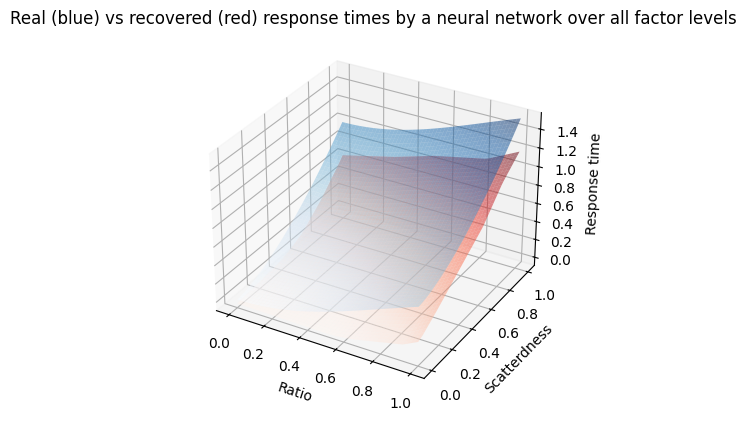

In [159]:
# plot the recovered response times over the conditions
# define the factor levels
x = np.linspace(0, 1)
y = np.linspace(0, 1)
x_mesh, y_mesh = np.meshgrid(x, y)
sample_size = len(x)

# initiate the z array
z_recovered = np.zeros((sample_size, sample_size))
z_real = np.zeros((sample_size, sample_size))

unit_id = 30

# collect the observations
for i in range(sample_size):
    condition = torch.tensor(np.stack((x_mesh[i], y_mesh[i]), axis=-1))
    unit_id_array = torch.full((condition.shape[0], 1), unit_id)
    X = torch.cat((unit_id_array, condition), axis=-1)

    z_recovered[i, :] = model.predict(X).reshape(-1)
    z_real[i, :] = experimental_units[unit_id].step(np.stack((x_mesh[i], y_mesh[i]), axis=-1), noise=False)

# make a surface plot to visualize the ground_truth
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x_mesh, y_mesh, z_recovered, cmap=cm.Reds, alpha=0.5)
ax.plot_surface(x_mesh, y_mesh, z_real, cmap=cm.Blues, alpha=0.5)
ax.set_title('Real (blue) vs recovered (red) response times by a neural network over all factor levels')
ax.set_xlabel('Ratio')
ax.set_ylabel('Scatterdness')
ax.set_zlabel('Response time')
plt.show()

### Autora base

In this section  we will prepare the [AutoRA](https://autoresearch.github.io/autora/) base to which we will later apply the approach of [Rajeswaran et al.](https://doi.org/10.48550/arXiv.2004.07804)

In [209]:
# ------------------------------
# Set random seeds for reproducibility
# ------------------------------
np.random.seed(42)
torch.manual_seed(42)

losses = []
# ------------------------------
# Initialize experiment settings
# ------------------------------
num_cycles = 5  # Number of empirical research cycles
n_samples = 10  # Number of samples to collect per cycle

# Define the experiment (assuming 'twoafc' experiment setup is already available)
experiment = twoafc(parameters)  # Create an instance of the experiment using the parameters

# ------------------------------
# Generate the initial experimental conditions
# ------------------------------
# Create a 2D grid of experimental conditions, where each condition has two independent variables
condition_pool = np.array(np.meshgrid(np.linspace(0, 2 * np.pi, 10),
                                      np.linspace(0, 2 * np.pi, 10))).T.reshape(-1, 2)

# Extract independent and dependent variables from the experiment setup
iv = experiment.variables.independent_variables
dv = experiment.variables.dependent_variables

# Define metadata for falsification sampling (includes both independent and dependent variables)
metadata = VariableCollection(
    independent_variables=experiment.variables.independent_variables,
    dependent_variables=experiment.variables.dependent_variables
)

# ------------------------------
# Define and train the theorist model
# ------------------------------
# Using BMSRegressor as the theorist model (fitting a model to predict the response based on input conditions)
theorist_bms = BMSRegressor(epochs=100)  # Initialize the theorist with 100 epochs for training

# Generate an initial set of experimental conditions with two independent variables
conditions = random_sampler(experiment.variables, sample_all=['participant_id'])  # Randomly sample conditions

# Collect initial set of observations by running the experiment with the generated conditions
observations = experiment.run(conditions)  # Run experiment to collect observations (e.g., response times)

# ------------------------------
# Extract relevant data for the analysis
# ------------------------------
# Get names of independent and dependent variables for experiment metadata
iv_names = [iv.name for iv in experiment.variables.independent_variables]
dv_names = [dv.name for dv in experiment.variables.dependent_variables]

# Extract only the response time (dependent variable) from the observations
observations = observations[['response_time']]

# Combine conditions and observations into a DataFrame for easy handling
experiment_data = pd.DataFrame(np.hstack((conditions, observations)), columns=iv_names + dv_names)

# ------------------------------
# Set up a grid of conditions for the falsification sampling
# ------------------------------
# Define participant IDs (ranging from 0 to 99)
participant_ids = np.arange(0, 100)

# Define 'ratios' and 'scatteredness' as the two independent variables (which vary between 0 and 2π)
ratios = np.linspace(0, 2 * np.pi, 10)
scatteredness = np.linspace(0, 2 * np.pi, 10)

# Create a 3D grid combining all independent variables (participant_id, ratio, scatteredness)
participant_ids_grid, ratios_grid, scatteredness_grid = np.meshgrid(participant_ids, ratios, scatteredness)

# Reshape the 3D grids into a 2D array of conditions (one row for each combination of independent variables)
condition_pool = np.vstack([participant_ids_grid.ravel(), ratios_grid.ravel(), scatteredness_grid.ravel()]).T

# ------------------------------
# Run the research cycles
# ------------------------------
for cycle in range(num_cycles):
    print(f"Cycle {cycle + 1} begins...")

    # Step 1: Fit the theorist's model to the observed data (conditions, observations)
    theorist_bms.fit(conditions, observations)
    print("Theorist model fitted.")

    # Step 2: Use falsification sampling to propose new experimental conditions
    new_conditions = falsification_sample(
        conditions=condition_pool,  # Existing conditions
        model=theorist_bms,  # Theorist model that will guide the sampling
        reference_conditions=conditions,  # Conditions from previous cycles
        reference_observations=observations,  # Observations from previous cycles
        metadata=metadata,  # Metadata of experiment variables
        num_samples=n_samples  # Number of new conditions to sample
    )
    print("New conditions sampled.")

    # Step 3: Run the experiment with the new conditions to obtain new observations
    new_observations = run_experiment(new_conditions)  # Collect new observations based on new conditions
    new_observations = new_observations.iloc[:, 2]  # Assuming 'response_time' is in column index 2
    new_observations = new_observations.to_frame()  # Convert to DataFrame for consistency

    # Step 4: Combine old conditions/observations with new ones to update the dataset
    conditions = np.concatenate((conditions, new_conditions))  # Update conditions
    observations = np.concatenate((observations, new_observations))  # Update observations

    # Step 5: Evaluate the theorist's model by calculating the loss (mean squared error)
    loss = np.mean(np.square(theorist_bms.predict(condition_pool) - ground_truth(condition_pool)))  # Compare model predictions with ground truth
    losses.append(loss)  # Append the loss for this cycle to the losses list
    print(f"Loss in cycle {cycle + 1}: {loss:.4f}")

    # Output the theorist's current model
    print(f"Discovered Model: {theorist_bms.repr()}\n")

Cycle 1 begins...


100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Theorist model fitted.
New conditions sampled.
Loss in cycle 1: 33.7126
Discovered Model: ((scatteredness + ratio) * 0.82)

Cycle 2 begins...


100%|██████████| 100/100 [00:13<00:00,  7.23it/s]


Theorist model fitted.
New conditions sampled.
Loss in cycle 2: 8.5939
Discovered Model: ((X2 / 0.61) ** 0.61)

Cycle 3 begins...


100%|██████████| 100/100 [00:13<00:00,  7.56it/s]


Theorist model fitted.
New conditions sampled.
Loss in cycle 3: 2.6099
Discovered Model: (X2 ** (X0 / 166.4))

Cycle 4 begins...


100%|██████████| 100/100 [00:13<00:00,  7.56it/s]


Theorist model fitted.
New conditions sampled.
Loss in cycle 4: 0.6559
Discovered Model: sin((0.4 + X2))

Cycle 5 begins...


100%|██████████| 100/100 [00:11<00:00,  8.67it/s]


Theorist model fitted.
New conditions sampled.
Loss in cycle 5: 0.7396
Discovered Model: ((0.59 ** 2) + sin(X2))



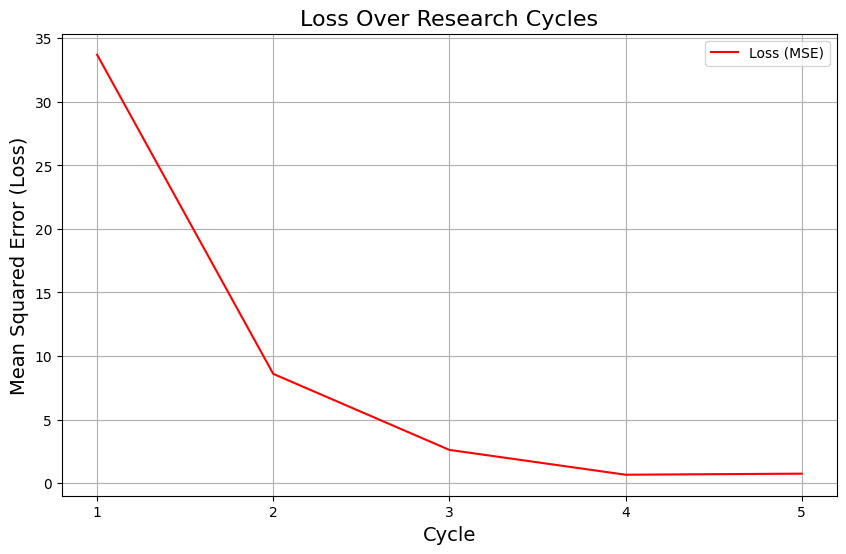

ValueError: Shape of passed values is (100, 2), indices imply (100, 3)

In [210]:
# Plot 1: Loss over Cycles
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_cycles + 1), losses, label="Loss (MSE)", color='red')
plt.title('Loss Over Research Cycles', fontsize=16)
plt.xlabel('Cycle', fontsize=14)
plt.ylabel('Mean Squared Error (Loss)', fontsize=14)
plt.xticks(range(1, num_cycles + 1))
plt.grid(True)
plt.legend()
plt.show()

# Plot 2: Theorist Model vs Ground Truth (3D surface plot of the predictions)
# Prepare 3D grid for conditions
x = np.linspace(0, 2 * np.pi, 10)
y = np.linspace(0, 2 * np.pi, 10)
x_mesh, y_mesh = np.meshgrid(x, y)
z_theorist = theorist_bms.predict(np.vstack([x_mesh.ravel(), y_mesh.ravel()]).T).reshape(x_mesh.shape)
z_real = ground_truth(np.vstack([x_mesh.ravel(), y_mesh.ravel()]).T).reshape(x_mesh.shape)

# Plot the surface
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_mesh, y_mesh, z_theorist, cmap='Reds', alpha=0.5, label="Theorist Prediction")
ax.plot_surface(x_mesh, y_mesh, z_real, cmap='Blues', alpha=0.5, label="Ground Truth")
ax.set_xlabel('Ratio', fontsize=14)
ax.set_ylabel('Scatteredness', fontsize=14)
ax.set_zlabel('Response Time', fontsize=14)
ax.set_title('Theorist Model vs Ground Truth', fontsize=16)
plt.show()

## The Framework
In this part we will now be applying the framework by [Rajeswaran et al.](https://doi.org/10.48550/arXiv.2004.07804) As a quick recap, their framework is based on a game theoretic MBRL framwork that is conceptualized as a stackelberg game. And we plan to  put the model  player of their framework into the theorist of [AutoRA](https://autoresearch.github.io/autora/) and their policy player into into the experimentalist of [AutoRA](https://autoresearch.github.io/autora/).

As we mentioned above we will be setting this up in the following way: Theorist == Model Player; Experimentalist == Policy Player.

The policy player’s goal is to reduce uncertainty by exploring regions where the model is weakest. This means that we look where the model has the lowest certainty. Then it adapts the experiment based on this. Hence, there is no real step where we decide the next action in an environment, but just get the feedback of uncertainity and adapt accordingly.

We learn the psychometric function dynamically (Theorist is a neural network or Gaussian process), so we should use MAL (Model as Leader): First, the Theorist (Model Player) improves its internal model. Then, the Experimentalist (Policy Player) selects optimal experiments based on the updated model.

Using PAL could be risky because if the Experimentalist (Policy Player) chooses poor conditions before the model improves, it might collect less useful data.

MAL ensures that experiment selection is based on the best available model.

Steps:
*    Theorist is trained on initial Latin Hypercube Sampling (LHS) data.
*    Theorist makes predictions about participant responses.
*    Experimentalist (Policy Player) checks which conditions have high uncertainty (low confidence).
*    Experimentalist selects the next condition to test.
*    Theorist updates its model based on this new data.
*    Repeat until the model is accurate enough.

In [207]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

losses = []

# Define the number of cycles and number of samples per cycle
num_cycles = 5
n_samples = 10

# Define the experiment (assuming twoafc is already set up)
experiment = twoafc(parameters)

# Create a 2D grid of conditions where each condition has two independent variables
condition_pool = np.array(np.meshgrid(np.linspace(0, 2 * np.pi, 10),
                                      np.linspace(0, 2 * np.pi, 10))).T.reshape(-1, 2)

# Extract variables from the experiment
iv = experiment.variables.independent_variables
dv = experiment.variables.dependent_variables

# Define metadata for falsification sampling
metadata = VariableCollection(
    independent_variables=experiment.variables.independent_variables,
    dependent_variables=experiment.variables.dependent_variables
)

# Define theorist (BMSRegressor for the theorist model)
theorist_bms = BMSRegressor(epochs=100)

# Generate an initial set of experimental conditions with two independent variables
conditions = random_sampler(experiment.variables, sample_all=['participant_id'])

# Collect initial set of observations
observations = experiment.run(conditions)  # Run experiment with initial conditions

# Initialize the state for experimentation
iv_names = [iv.name for iv in experiment.variables.independent_variables]
dv_names = [dv.name for dv in experiment.variables.dependent_variables]
observations = observations[['response_time']]

# Initialize state with actual experiment data
experiment_data = pd.DataFrame(np.hstack((conditions, observations)), columns=iv_names + dv_names)

# Create 3D grid for independent variables (for experimentation)
participant_ids = np.arange(0, 100)  # participant_id ranges from 0 to 99
ratios = np.linspace(0, 2 * np.pi, 10)  # ratio varies between 0 and 2π
scatteredness = np.linspace(0, 2 * np.pi, 10)  # scatteredness varies between 0 and 2π

# Create meshgrid for ratio and scatteredness, then combine with participant_id
participant_ids_grid, ratios_grid, scatteredness_grid = np.meshgrid(participant_ids, ratios, scatteredness)
condition_pool = np.vstack([participant_ids_grid.ravel(), ratios_grid.ravel(), scatteredness_grid.ravel()]).T

# Define strategy adjustments for theorist and experimentalist

def adjust_theorist_model(theorist_bms, theorist_reward):
    """
    Adjusts the theorist's model complexity based on its reward (accuracy).
    """
    if theorist_reward < -0.2:  # If theorist's model is performing poorly
        theorist_bms = increase_model_complexity(theorist_bms)  # Increase complexity
        print("Theorist is increasing model complexity")
    elif theorist_reward > 0.2:  # If theorist's model is doing well
        theorist_bms = decrease_model_complexity(theorist_bms)  # Decrease complexity to avoid overfitting
        print("Theorist is decreasing model complexity")
    return theorist_bms

def increase_model_complexity(theorist):
    """
    Increases the theorist's model complexity by modifying priors or features.
    """
    # Example: Add more epochs or modify priors for more exploration
    theorist.prior_par['some_param'] = 'new_value'
    theorist.epochs += 50  # Increase epochs for more exploration
    return theorist

def decrease_model_complexity(theorist):
    """
    Decreases the theorist's model complexity to avoid overfitting.
    """
    # Example: Tighten priors, reduce epochs
    theorist.prior_par['some_param'] = 'simpler_value'
    theorist.epochs -= 50
    return theorist

def adjust_experimentalist_sampling(experimentalist_reward, conditions, condition_pool, theorist_bms):
    """
    Adjusts the experimentalist's sampling strategy based on its reward (uncertainty).
    """
    if experimentalist_reward > 0.5:  # If experimentalist is performing well
        new_conditions = falsification_sample(
            conditions=condition_pool,
            model=theorist_bms,
            reference_conditions=conditions,
            reference_observations=observations,
            metadata=metadata,
            num_samples=n_samples * 2  # Increase the number of samples to explore more
        )
        print("Experimentalist is increasing exploration")
    else:  # If experimentalist is performing poorly
        new_conditions = falsification_sample(
            conditions=condition_pool,
            model=theorist_bms,
            reference_conditions=conditions,
            reference_observations=observations,
            metadata=metadata,
            num_samples=n_samples // 2  # Reduce the number of samples
        )
        print("Experimentalist is decreasing exploration")

    return new_conditions

# Simulate interaction between the theorist and experimentalist over multiple cycles
for cycle in range(num_cycles):
    print(f"Cycle {cycle + 1} begins")

    # Step 1: Theorist's Turn (Model Player)
    theorist_bms.fit(conditions, observations)
    theorist_predictions = theorist_bms.predict(conditions)

    theorist_reward = theorist_payoff(theorist_predictions, observations)
    print(f"Theorist's payoff: {theorist_reward}")

    # Adjust theorist's model based on its performance (payoff)
    theorist_bms = adjust_theorist_model(theorist_bms, theorist_reward)

    # Step 2: Experimentalist's Turn (Policy Player)
    experimentalist_reward = experimentalist_payoff(theorist_predictions, observations, conditions)
    new_conditions = adjust_experimentalist_sampling(experimentalist_reward, conditions, condition_pool, theorist_bms)

    print(f"Experimentalist's payoff: {experimentalist_reward}")

    # Step 3: Experiment (Get new observations for selected conditions)
    new_observations = run_experiment(new_conditions)  # Run experiment to collect new data
    new_observations = new_observations.iloc[:, 2].to_frame()

    # Combine old and new conditions and observations
    conditions = np.concatenate((conditions, new_conditions))
    observations = np.concatenate((observations, new_observations))

    cycle_loss = np.mean(np.square(theorist_bms.predict(condition_pool) - ground_truth(condition_pool)))
    losses.append(cycle_loss)  # Append the loss for this cycle to the losses list
    # Evaluate the overall system (Optional: Nash equilibrium test)
    print(f"Loss in cycle {cycle + 1}: {np.mean(np.square(theorist_bms.predict(condition_pool) - ground_truth(condition_pool)))}")

Cycle 1 begins


100%|██████████| 100/100 [00:13<00:00,  7.65it/s]


Theorist's payoff: -0.04269562643943388
Experimentalist is decreasing exploration
Experimentalist's payoff: 0.14701505064002351
Loss in cycle 1: 471.79203012813406
Cycle 2 begins


100%|██████████| 100/100 [00:12<00:00,  7.76it/s]


Theorist's payoff: -0.043872106927134905
Experimentalist is decreasing exploration
Experimentalist's payoff: 0.14820471055467951
Loss in cycle 2: 2.778825817328377
Cycle 3 begins


100%|██████████| 100/100 [00:12<00:00,  8.31it/s]


Theorist's payoff: -0.05012828568096058
Experimentalist is decreasing exploration
Experimentalist's payoff: 0.16698423991127265
Loss in cycle 3: 1.4515149319009193
Cycle 4 begins


100%|██████████| 100/100 [00:08<00:00, 11.26it/s]


Theorist's payoff: -0.05777941003962588
Experimentalist is decreasing exploration
Experimentalist's payoff: 0.16743427477116904
Loss in cycle 4: 0.9713839136098193
Cycle 5 begins


100%|██████████| 100/100 [00:08<00:00, 11.57it/s]


Theorist's payoff: -0.09517305392202638
Experimentalist is decreasing exploration
Experimentalist's payoff: 0.23732656197983007
Loss in cycle 5: 0.9786867017149938


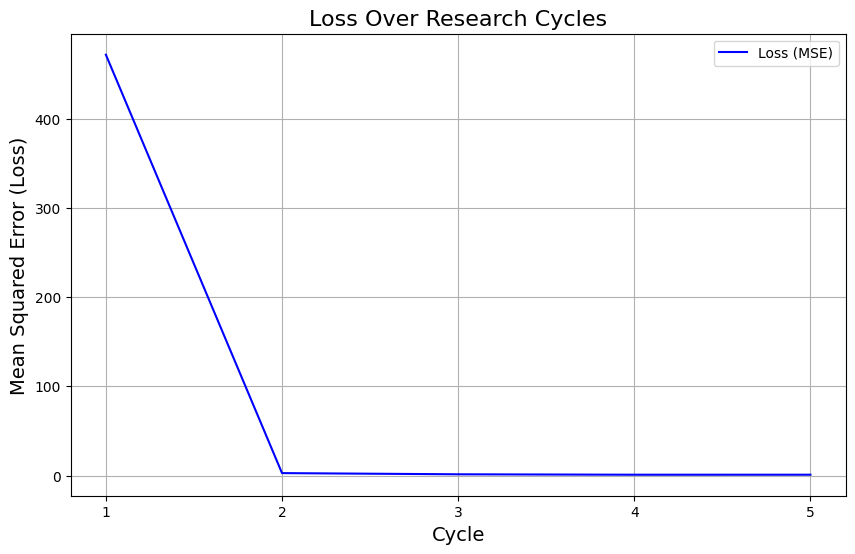

ValueError: Shape of passed values is (100, 2), indices imply (100, 3)

In [208]:
# Plot 1: Loss over Cycles
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_cycles + 1), losses, label="Loss (MSE)", color='blue')
plt.title('Loss Over Research Cycles', fontsize=16)
plt.xlabel('Cycle', fontsize=14)
plt.ylabel('Mean Squared Error (Loss)', fontsize=14)
plt.xticks(range(1, num_cycles + 1))
plt.grid(True)
plt.legend()
plt.show()

# Plot 2: Theorist Model vs Ground Truth (3D surface plot of the predictions)
# Prepare 3D grid for conditions
x = np.linspace(0, 2 * np.pi, 10)
y = np.linspace(0, 2 * np.pi, 10)
x_mesh, y_mesh = np.meshgrid(x, y)
z_theorist = theorist_bms.predict(np.vstack([x_mesh.ravel(), y_mesh.ravel()]).T).reshape(x_mesh.shape)
z_real = ground_truth(np.vstack([x_mesh.ravel(), y_mesh.ravel()]).T).reshape(x_mesh.shape)

# Plot the surface
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_mesh, y_mesh, z_theorist, cmap='Reds', alpha=0.5, label="Theorist Prediction")
ax.plot_surface(x_mesh, y_mesh, z_real, cmap='Blues', alpha=0.5, label="Ground Truth")
ax.set_xlabel('Ratio', fontsize=14)
ax.set_ylabel('Scatteredness', fontsize=14)
ax.set_zlabel('Response Time', fontsize=14)
ax.set_title('Theorist Model vs Ground Truth', fontsize=16)
plt.show()

#### This code sadly does not work yet

In [188]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Define the number of cycles and number of samples per cycle
num_cycles = 5
n_samples = 10

# Define the experiment (assuming twoafc is already set up)
experiment = twoafc(parameters)

# Create a 2D grid of conditions where each condition has two independent variables
condition_pool = np.array(np.meshgrid(np.linspace(0, 2 * np.pi, 10),
                                      np.linspace(0, 2 * np.pi, 10))).T.reshape(-1, 2)

# Extract variables from the experiment
iv = experiment.variables.independent_variables
dv = experiment.variables.dependent_variables

# Define metadata for falsification sampling
metadata = VariableCollection(
    independent_variables=experiment.variables.independent_variables,
    dependent_variables=experiment.variables.dependent_variables
)

# Define theorist (BMSRegressor for the theorist model)
theorist_bms = BMSRegressor(epochs=100)

# Generate an initial set of experimental conditions with two independent variables
conditions = random_sampler(experiment.variables, sample_all=['participant_id'])

# Collect initial set of observations
observations = experiment.run(conditions)  # Run experiment with initial conditions

# Initialize the state for experimentation
iv_names = [iv.name for iv in experiment.variables.independent_variables]
dv_names = [dv.name for dv in experiment.variables.dependent_variables]
observations = observations[['response_time']]

# Initialize state with actual experiment data
experiment_data = pd.DataFrame(np.hstack((conditions, observations)), columns=iv_names + dv_names)

# Create 3D grid for independent variables (for experimentation)
participant_ids = np.arange(0, 100)  # participant_id ranges from 0 to 99
ratios = np.linspace(0, 2 * np.pi, 10)  # ratio varies between 0 and 2π
scatteredness = np.linspace(0, 2 * np.pi, 10)  # scatteredness varies between 0 and 2π

# Create meshgrid for ratio and scatteredness, then combine with participant_id
participant_ids_grid, ratios_grid, scatteredness_grid = np.meshgrid(participant_ids, ratios, scatteredness)
condition_pool = np.vstack([participant_ids_grid.ravel(), ratios_grid.ravel(), scatteredness_grid.ravel()]).T

# Define strategy adjustments for theorist and experimentalist

def experimentalist_payoff(theorist_predictions, observed_data, conditions):
    """
    Calculates the experimentalist's payoff based on the theorist's predictions.
    """
    # Ensure both the predictions and observations have the same number of samples
    if len(theorist_predictions) != len(observed_data):
        raise ValueError(f"Shape mismatch: predictions ({len(theorist_predictions)}) and observations ({len(observed_data)})")

    # Calculate uncertainty based on prediction error
    uncertainty = np.mean(np.abs(theorist_predictions - observed_data))  # Can use other uncertainty metrics
    return uncertainty


def adjust_theorist_model(theorist_bms, theorist_reward):
    """
    Adjusts the theorist's model complexity based on its reward (accuracy).
    """
    if theorist_reward < -0.2:  # If theorist's model is performing poorly
        theorist_bms = increase_model_complexity(theorist_bms)  # Increase complexity
        print("Theorist is increasing model complexity")
    elif theorist_reward > 0.2:  # If theorist's model is doing well
        theorist_bms = decrease_model_complexity(theorist_bms)  # Decrease complexity to avoid overfitting
        print("Theorist is decreasing model complexity")
    return theorist_bms

def increase_model_complexity(theorist):
    """
    Increases the theorist's model complexity by modifying priors or features.
    """
    # Example: Add more epochs or modify priors for more exploration
    theorist.prior_par['some_param'] = 'new_value'
    theorist.epochs += 50  # Increase epochs for more exploration
    return theorist

def decrease_model_complexity(theorist):
    """
    Decreases the theorist's model complexity to avoid overfitting.
    """
    # Example: Tighten priors, reduce epochs
    theorist.prior_par['some_param'] = 'simpler_value'
    theorist.epochs -= 50
    return theorist

def adjust_experimentalist_sampling(experimentalist_reward, conditions, condition_pool, theorist_bms):
    """
    Adjusts the experimentalist's sampling strategy based on its reward (uncertainty).
    """
    if experimentalist_reward > 0.5:  # If experimentalist is performing well
        new_conditions = falsification_sample(
            conditions=condition_pool,
            model=theorist_bms,
            reference_conditions=conditions,
            reference_observations=observations,
            metadata=metadata,
            num_samples=n_samples * 2  # Increase the number of samples to explore more
        )
        print("Experimentalist is increasing exploration")
    else:  # If experimentalist is performing poorly
        new_conditions = falsification_sample(
            conditions=condition_pool,
            model=theorist_bms,
            reference_conditions=conditions,
            reference_observations=observations,
            metadata=metadata,
            num_samples=n_samples // 2  # Reduce the number of samples
        )
        print("Experimentalist is decreasing exploration")

    return new_conditions

def is_nash_equilibrium(theorist_bms, theorist_reward, experimentalist_reward, conditions, condition_pool):
    theorist_increase = increase_model_complexity(theorist_bms)
    theorist_decrease = decrease_model_complexity(theorist_bms)

    theorist_increase_reward = theorist_payoff(theorist_increase.predict(conditions), observations)
    theorist_decrease_reward = theorist_payoff(theorist_decrease.predict(conditions), observations)

    experimentalist_increase_conditions = adjust_experimentalist_sampling(experimentalist_reward, conditions, condition_pool, theorist_bms)
    experimentalist_decrease_conditions = adjust_experimentalist_sampling(experimentalist_reward, conditions, condition_pool, theorist_decrease)

    # Run new experiments and predict new observations
    new_observations_increase = run_experiment(theorist_bms.predict(experimentalist_increase_conditions))
    new_observations_decrease = run_experiment(theorist_bms.predict(experimentalist_decrease_conditions))

    # Convert to DataFrame if they are not already
    new_observations_increase = pd.DataFrame(new_observations_increase)
    new_observations_decrease = pd.DataFrame(new_observations_decrease)

    # Adjust column indexing as needed for the new observation data
    new_observations_increase = new_observations_increase.iloc[:, 2].to_frame()
    new_observations_decrease = new_observations_decrease.iloc[:, 2].to_frame()

    experimentalist_increase_reward = experimentalist_payoff(theorist_bms.predict(experimentalist_increase_conditions), observations, new_observations_increase)
    experimentalist_decrease_reward = experimentalist_payoff(theorist_bms.predict(experimentalist_decrease_conditions), observations, new_observations_decrease)

    theorist_best_response = theorist_reward >= max(theorist_increase_reward, theorist_decrease_reward)
    experimentalist_best_response = experimentalist_reward >= max(experimentalist_increase_reward, experimentalist_decrease_reward)

    if theorist_best_response and experimentalist_best_response:
        print("Nash equilibrium reached.")
        return True
    else:
        print("No Nash equilibrium yet.")
        return False


# Simulate interaction between the theorist and experimentalist over multiple cycles
for cycle in range(num_cycles):
    print(f"Cycle {cycle + 1} begins")

    # Step 1: Theorist's Turn (Model Player)
    theorist_bms.fit(conditions, observations)
    theorist_predictions = theorist_bms.predict(conditions)

    theorist_reward = theorist_payoff(theorist_predictions, observations)
    print(f"Theorist's payoff: {theorist_reward}")

    # Adjust theorist's model based on its performance (payoff)
    theorist_bms = adjust_theorist_model(theorist_bms, theorist_reward)

    # Step 2: Experimentalist's Turn (Policy Player)
    experimentalist_reward = experimentalist_payoff(theorist_predictions, observations, conditions)
    new_conditions = adjust_experimentalist_sampling(experimentalist_reward, conditions, condition_pool, theorist_bms)

    print(f"Experimentalist's payoff: {experimentalist_reward}")

    # Step 3: Experiment (Get new observations for selected conditions)
    new_observations = run_experiment(new_conditions)  # Run experiment to collect new data
    new_observations = new_observations.iloc[:, 2].to_frame()

    # Combine old and new conditions and observations
    conditions = np.concatenate((conditions, new_conditions))
    observations = np.concatenate((observations, new_observations))

    print(conditions.shape)
    print(observations.shape)
    # Check for Nash equilibrium
    if is_nash_equilibrium(theorist_bms, theorist_reward, experimentalist_reward, conditions, condition_pool):
        break

    # Evaluate the overall system (Optional: Nash equilibrium test)
    print(f"Loss in cycle {cycle + 1}: {np.mean(np.square(theorist_bms.predict(condition_pool) - ground_truth(condition_pool)))}")


Cycle 1 begins


100%|██████████| 100/100 [00:10<00:00,  9.76it/s]


Theorist's payoff: -0.10288758963911786
Experimentalist is decreasing exploration
Experimentalist's payoff: 0.28217752804197566
(55, 3)
(55, 1)
Experimentalist is decreasing exploration
Experimentalist is decreasing exploration


IndexError: single positional indexer is out-of-bounds